# Geohashの桁数(精度)と矩形サイズの確認

Geohash ([Wikipediaリンク](https://en.wikipedia.org/wiki/Geohash)) は経緯度を8x4、4x8の順に等分割した矩形領域をキーとするため、高緯度・低緯度で矩形サイズに差があると考えられる。  
日本全国で利用可能なことを確認するため、高緯度・低緯度地域でのGeohashの矩形サイズを桁数(精度)を変えて確認する。

### 確認地点

Wikipediaの [日本の端の一覧#自由に到達可能な東西南北端](https://ja.wikipedia.org/wiki/%E6%97%A5%E6%9C%AC%E3%81%AE%E7%AB%AF%E3%81%AE%E4%B8%80%E8%A6%A7#%E8%87%AA%E7%94%B1%E3%81%AB%E5%88%B0%E9%81%94%E5%8F%AF%E8%83%BD%E3%81%AA%E6%9D%B1%E8%A5%BF%E5%8D%97%E5%8C%97%E7%AB%AF) より最北端・最南端付近の座標で確認
- 最北端
  - 場所: 宗谷岬付近
  - 座標値(緯度, 経度): 45.522831, 141.936591
  - [OSMリンク](https://www.openstreetmap.org/?mlat=45.522831&mlon=141.936591#map=19/45.522831/141.936591)
  - 平面直角座標系: 第12系 (EPSG:6680)
- 最南端
  - 場所: 波照間島・高那崎付近
  - 座標値(緯度, 経度): 24.047989, 123.794893
  - [OSMリンク](https://www.openstreetmap.org/?mlat=24.047989&mlon=123.794893#map=19/24.047989/123.794893)
  - 平面直角座標系: 第16系 (EPSG:6684)

### 参考リンク

geohashモジュール(`python-geohash`)の用例は以下のQiita記事を参考
* [Geohashの個人的メモ #Python - Qiita](https://qiita.com/t2murata/items/3866c8d73a32b0a1ec3d)

### 桁数(精度)と矩形サイズの確認

In [1]:
import geohash
import matplotlib.pyplot as plt
from pyproj import Transformer
from shapely import box, Polygon, minimum_bounding_radius
from shapely.plotting import plot_polygon
import matplotlib.font_manager as fm

# 日本語フォントを設定
font_path = "/System/Library/Fonts/Supplemental/Arial Unicode.ttf"  # macOSの場合
# font_path = "/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf"  # Linuxの場合
# font_path = "C:\\Windows\\Fonts\\meiryo.ttc"  # Windowsの場合

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [2]:
# Geohashの桁数(精度)を変更しての確認のため、関数を作成
def print_geohash_size(digits):
    # 緯度経度から指定桁精度のGeohash値を取得
    north_code = geohash.encode(45.522831, 141.936591, digits)
    print(f"最北端のGeohash値: {north_code}")
    
    south_code = geohash.encode(24.047989, 123.794893, digits)
    print(f"最南端のGeohash値: {south_code}")

    # Geohash値から中心の経緯度を取得(緯度・経度=>経度・緯度の順に変更)
    north_center = tuple(reversed(geohash.decode(north_code)))
    south_center = tuple(reversed(geohash.decode(south_code)))

    # Geohash値から上下左右の緯度経度領域を取得
    north_bbox = geohash.bbox(north_code)
    # print(f'最北端の緯度経度領域: {north_bbox}')
    
    south_bbox = geohash.bbox(south_code)
    # print(f'最南端の緯度経度領域: {south_bbox}')

    # 各緯度経度領域から矩形ポリゴンを作成
    north_polygon = box(north_bbox['w'], north_bbox['s'], north_bbox['e'], north_bbox['n'])
    # print(f'最北端の矩形ポリゴン(経緯度座標系): {north_polygon}')
    
    south_polygon = box(south_bbox['w'], south_bbox['s'], south_bbox['e'], south_bbox['n'])
    # print(f'最北端の矩形ポリゴン(経緯度座標系): {south_polygon}')

    # 中心・矩形ポリゴンを経緯度座標系から平面直角座標系に変換
    north_coords = north_polygon.exterior.coords
    north_transformer = Transformer.from_crs(4326, 6680)
    north_projected_center = list(north_transformer.itransform([north_center], switch=True))[0]
    # print(f'\t最北端の中心(平面直角座標系): {north_projected_center}')
    north_projected_coords = north_transformer.itransform(north_coords, switch=True)
    north_projected_polygon = Polygon(north_projected_coords)
    # print(f'\t最北端の矩形ポリゴン(平面直角座標系): {north_projected_polygon}')
    
    south_coords = south_polygon.exterior.coords
    south_transformer = Transformer.from_crs(4326, 6684)
    south_projected_center = list(south_transformer.itransform([south_center], switch=True))[0]
    # print(f'\t最南端の中心(平面直角座標系): {south_projected_center}')
    south_projected_coords = south_transformer.itransform(south_coords, switch=True)
    south_projected_polygon = Polygon(south_projected_coords)
    # print(f'\t最南端の矩形ポリゴン(平面直角座標系): {south_projected_polygon}')

    # 平面直角座標系での幅、高さ、最小外接円半径を取得
    north_projected_extent = north_projected_polygon.bounds
    north_projected_width = north_projected_extent[2] - north_projected_extent[0]
    north_projected_height = north_projected_extent[3] - north_projected_extent[1]
    north_projected_minimum_bounding_radius = minimum_bounding_radius(north_projected_polygon)
    print(f"""最北端の矩形ポリゴン(平面直角座標系)
        幅: {north_projected_width}[m]
        高さ: {north_projected_height}[m]
        最小外接円半径: {north_projected_minimum_bounding_radius}[m]""")
    
    south_projected_extent = south_projected_polygon.bounds
    south_projected_width = south_projected_extent[2] - south_projected_extent[0]
    south_projected_height = south_projected_extent[3] - south_projected_extent[1]
    south_projected_minimum_bounding_radius = minimum_bounding_radius(south_projected_polygon)
    print(f"""最南端の矩形ポリゴン(平面直角座標系)
        幅: {south_projected_width}[m]
        高さ: {south_projected_height}[m]
        最小外接円半径: {south_projected_minimum_bounding_radius}[m]""")

    max_width = max(north_projected_width, south_projected_width, 1) * 1.1 # 少し余白を持たせる
    max_height = max(north_projected_height, south_projected_height, 1) * 1.1 # 少し余白を持たせる
    north_xlim = (north_projected_center[0] - (max_width / 2), north_projected_center[0] + (max_width / 2))
    north_ylim = (north_projected_center[1] - (max_height / 2), north_projected_center[1] + (max_height / 2))
    south_xlim = (south_projected_center[0] - (max_width / 2), south_projected_center[0] + (max_width / 2))
    south_ylim = (south_projected_center[1] - (max_height / 2), south_projected_center[1] + (max_height / 2))
    
    # プロットの作成
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # 最北端のポリゴン
    axes[0].set_title("最北端の矩形ポリゴン(平面直角座標系)")
    axes[0].set_xlabel("X座標 (m)")
    axes[0].set_ylabel("Y座標 (m)")
    axes[0].ticklabel_format(style='plain', axis='both')  # X・Y軸を通常の数値表記にする
    axes[0].set_aspect('equal')  # X・Y 軸のスケールを同じにする
    axes[0].set_xlim(north_xlim)
    axes[0].set_ylim(north_ylim)
    plot_polygon(north_projected_polygon, ax=axes[0], add_points=False)

    # 最南端のポリゴン
    axes[1].set_title("最南端の矩形ポリゴン(平面直角座標系)")
    axes[1].set_xlabel("X座標 (m)")
    axes[1].set_ylabel("Y座標 (m)")
    axes[1].ticklabel_format(style='plain', axis='both')  # X・Y軸を通常の数値表記にする
    axes[1].set_aspect('equal')  # X・Y 軸のスケールを同じにする
    axes[1].set_xlim(south_xlim)
    axes[1].set_ylim(south_ylim)
    plot_polygon(south_projected_polygon, ax=axes[1], add_points=False)

    plt.tight_layout()
    plt.show()

最北端のGeohash値: z0hfvz5jdq
最南端のGeohash値: wu20c1b9wn
最北端の矩形ポリゴン(平面直角座標系)
        幅: 0.8404488667983969[m]
        高さ: 0.5994235534453765[m]
        最小外接円半径: 0.5142621798278313[m]
最南端の矩形ポリゴン(平面直角座標系)
        幅: 1.0920351181775914[m]
        高さ: 0.5956920113239903[m]
        最小外接円半径: 0.621209911377764[m]


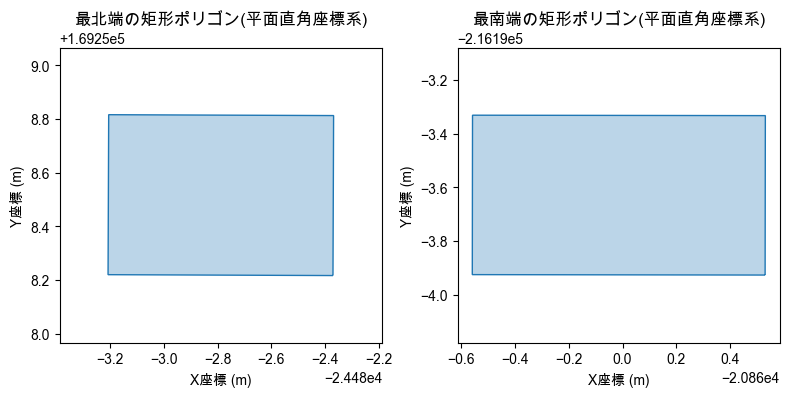

In [3]:
# 10桁での矩形サイズ
print_geohash_size(10)

最北端のGeohash値: z0hfvz5jdqc
最南端のGeohash値: wu20c1b9wn4
最北端の矩形ポリゴン(平面直角座標系)
        幅: 0.10534695833848673[m]
        高さ: 0.14944699211628176[m]
        最小外接円半径: 0.09108871528402321[m]
最南端の矩形ポリゴン(平面直角座標系)
        幅: 0.13661272429089877[m]
        高さ: 0.14872403524350375[m]
        最小外接円半径: 0.10082616966198603[m]


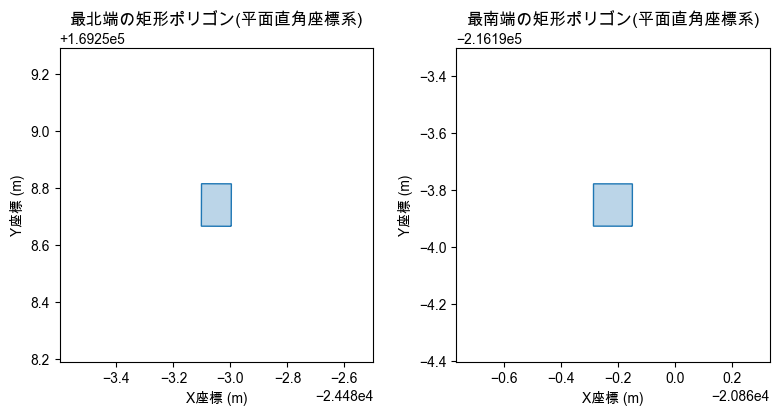

In [4]:
# 11桁での矩形サイズ
print_geohash_size(11)

### まとめ

上記より、日本国内ではGeohashが10桁の場合、幅が0.84\~1.09\[m\]、高さが0.595\~0.599\[m\]、最小外接円半径が0.51\~0.62\[m\]、Geohashが11桁の場合、幅が0.10\~0.13\[m\]、高さが0.148\~0.149\[m\]、最小外接円半径が0.091\~0.100\[m\]となるが、例えばPLATEAUの建築物モデル（LOD0）では取得基準が「射影の短辺の実長 1m 以上」となっていて([PLATEAU仕様書リンク](https://www.mlit.go.jp/plateau/file/libraries/doc/plateau_doc_0001_ver04.pdf))、最小で 1m の幅・奥行きの建物ポリゴンが存在する可能性があるため、Geohashの桁数については安全を取って11桁を採用する形とする。

経緯度座標系で10cm程度の精度に必要な小数点以下桁数は6桁とされていて、例にある `45.522831, 141.936591` の場合に、記号(`.`, `,`, ` `)を除いて固定長とした場合も、文字数は17桁必要となることから、17桁=>11桁に十分圧縮できていると考える。